## Mini-projet notebook template

- If you work on Google Colab, [![open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/jouvetg/glamod/blob/main/03_notebook/my_glacier.ipynb) and you will donwload the repo  below. Make sure to activate the GPU on Colab "Runtime" -> "Change Runtime Type" -> Slect GPU.

- If you work locally on your own PC, you can download the repo
```bash
git clone --depth 1 https://github.com/jouvetg/glamod.git
```
and then go the notebook folder, and work from there.

## Install IGM

Running IGM consists of running a python script `igm_run`, which is made of functions of the `igm` python package.  First of all, one needs to install igm as follows: (this may take a while, and it may crashes the first time, but should work the second time).

In [8]:
! pip install -i https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple igm-model-testing-package==3.0.5
! pip install ml-dtypes==0.5.3

Looking in indexes: https://test.pypi.org/simple/, https://pypi.org/simple
  Using cached ml_dtypes-0.4.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached ml_dtypes-0.4.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.2 MB)
  Attempting uninstall: ml-dtypes
    Found existing installation: ml_dtypes 0.5.3
    Uninstalling ml_dtypes-0.5.3:
      Successfully uninstalled ml_dtypes-0.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.17.1 which is incompatible.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.17.1 which is incompatible.
tensorstore 0.1.79 requires ml_dtypes>=0.5.0, but you have ml-dtypes 0.4.1 which is incompatible.
jaxlib 0.7.2 requires ml_dtypes>=0.5.0, but you have ml-dtypes 0.4.1 

## Download the data

Let's now download the repo with the data if you are using Colab

In [9]:
import sys, os

if "google.colab" in sys.modules:
    print("Running in Colab: cloning repo...")
    !git clone --depth 1 https://github.com/jouvetg/glamod.git
    !apt-get install tree -q
else:
    print("Running locally: using local files.")

Running in Colab: cloning repo...
Cloning into 'glamod'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 81 (delta 10), reused 57 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (81/81), 14.05 MiB | 15.88 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Reading package lists...
Building dependency tree...
Reading state information...
tree is already the newest version (2.0.2-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


Let's now go the working folder

In [10]:
if "google.colab" in sys.modules:
    %cd /content/glamod/03_notebook

/content/glamod/03_notebook


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Modelling

Here, we model the Rhone Glacier (`RGI2000-v7.0-G-11-01706`) with IGM.

Wuse the module `oggm_shop` to download all necessary data. OGGM will download climate data (a time series), which will serve to generate a climate (temperature and precipitation in module `clim_oggm`) to compute a better Surface Mass Balance model. Note this parameter in the parameter file:

```yaml
  clim_oggm:
    clim_trend_array:
      - ["time", "delta_temp", "prec_scal"]
      - [ 1900,           0.0,         1.0]
      - [ 2020,           0.0,         1.0]
      - [ 2100,           4.0,         1.0]
```

Similar to the previous method, this array assigns weights to modify precipitation and temperature series based on a *neutral* climate period, typically defined as 1960-1990. By adjusting the temperature offset in the `delta_temp` column, for example, a value of -2.0 would create a climate scenario for the 1960-1990 period that is 2 degrees cooler. Likewise, by modifying the precipitation scaling in the `prec_scal` column, a value of 1.5 would result in a climate scenario that has 150% of the precipitation compared to the 1960-1990 average.

Finally, you can incorporate this parameter to provide global control for melt (note that the melt parameters in the PDD model are notoriously uncertain):

```yaml
   melt_enhancer: 0.7
```

Find more information about the generated climate [here](https://igm-model.org/latest/modules/processes/clim_oggm/).

Instead of using the Simple Surface Mass Balance `smb_simple`, and now that we have climate available, we will use the `smb_oggm` SMB, which is a monthly temperature index model as described [here](https://igm-model.org/latest/modules/processes/smb_oggm/).

Let's run IGM

In [97]:
! igm_run +experiment=params_findel

2025-12-05 17:17:40.972124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-05 17:17:40.992807: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-05 17:17:40.998958: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-05 17:17:41.015516: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-05 17:17:43.775444: W tensorflow/comp

## Visualizing Climate Data

Let's explore the historical climate data that was used for the glacier simulation. We will open the `climate_historical.nc` file and plot the smoothed precipitation and temperature time series on the same graph.

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import uniform_filter1d

# Open the climate data
climate_data = xr.open_dataset('data/RGI2000-v7.0-G-11-01706/climate_historical.nc')

# Extract temperature and precipitation
temp = climate_data['temp'].values
prcp = climate_data['prcp'].values
time = climate_data['time'].values

# Apply smoothing (moving average with window size of 12 months for annual smoothing)
window_size = 12
temp_smoothed = uniform_filter1d(temp, size=window_size, mode='nearest')
prcp_smoothed = uniform_filter1d(prcp, size=window_size, mode='nearest')

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot temperature on the left y-axis
color = 'tab:red'
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('Temperature (°C)', color=color, fontsize=12)
ax1.plot(time, temp_smoothed, color=color, linewidth=2, label='Temperature (smoothed)')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Create second y-axis for precipitation
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Precipitation (mm)', color=color, fontsize=12)
ax2.plot(time, prcp_smoothed, color=color, linewidth=2, label='Precipitation (smoothed)')
ax2.tick_params(axis='y', labelcolor=color)

# Add title and layout
plt.title('Historical Climate Data (Smoothed)', fontsize=14, fontweight='bold')
fig.tight_layout()

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

# Display some basic statistics
print(f"\nClimate Data Summary:")
print(f"Time period: {time[0]} to {time[-1]}")
print(f"Temperature range: {temp.min():.2f}°C to {temp.max():.2f}°C")
print(f"Mean temperature: {temp.mean():.2f}°C")
print(f"Precipitation range: {prcp.min():.2f} to {prcp.max():.2f} mm")
print(f"Mean precipitation: {prcp.mean():.2f} mm")

### Analyzing the time series results

Let's examine how the glacier evolved under the climate scenario:

Found 1 time series file(s). Using: outputs/2025-12-05/15-09-48/output_ts.nc

Reading time series data from: /content/glamod/03_notebook/outputs/2025-12-05/15-09-48/output_ts.nc



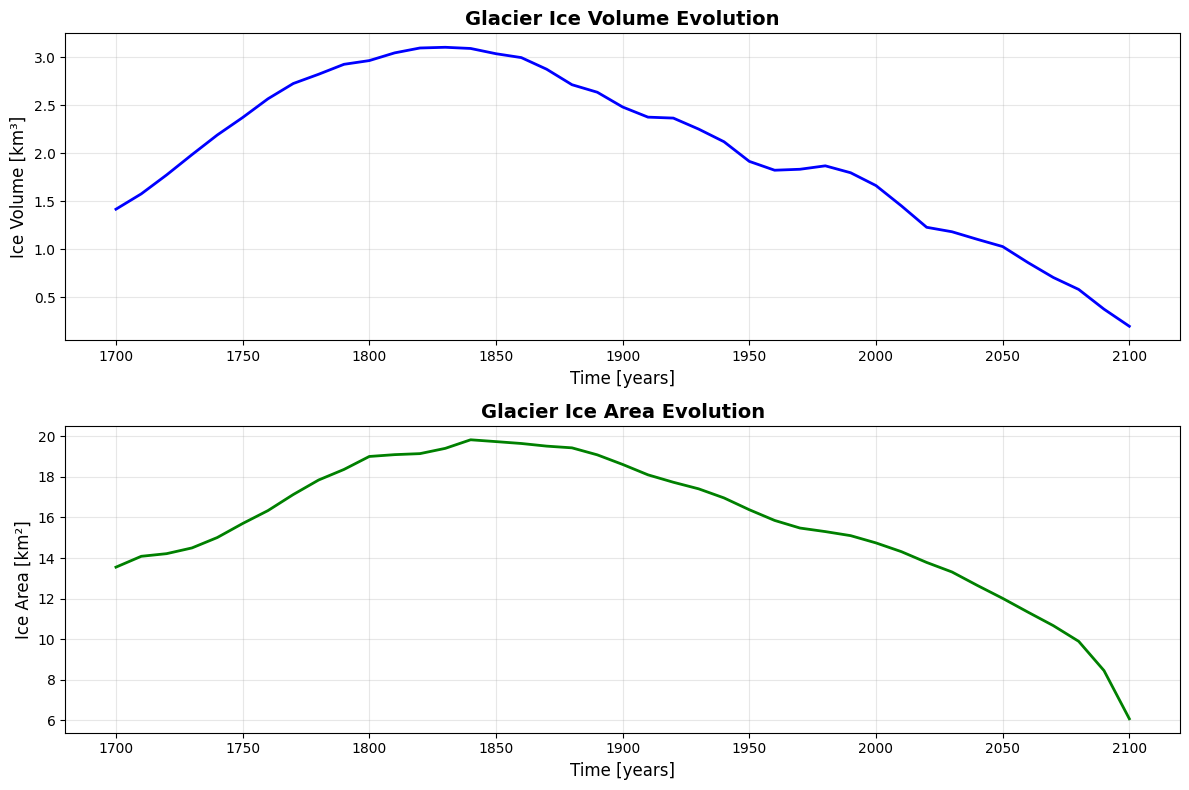


SUMMARY STATISTICS

Ice Volume:
  Initial: 1.42 km³
  Final:   0.20 km³
  Change:  -1.22 km³

Ice Area:
  Initial: 13.55 km²
  Final:   6.08 km²
  Change:  -7.47 km²


In [13]:
from helper import *
import glob
import os

# Find all time series files and select the most recent one
ts_files = sorted(glob.glob('outputs/*/*/output_ts.nc'))

if ts_files:
    # Get the absolute path to ensure it works from any directory
    ts_file = os.path.abspath(ts_files[-1])
    print(f"Found {len(ts_files)} time series file(s). Using: {ts_files[-1]}\n")
    # Analyze the time series from the most recent run
    analyze_time_series(ts_file)
else:
    print("No output_ts.nc file found. Please run the model first.")

Using: /content/glamod/03_notebook/outputs/2025-12-05/15-09-48/output_ts.nc


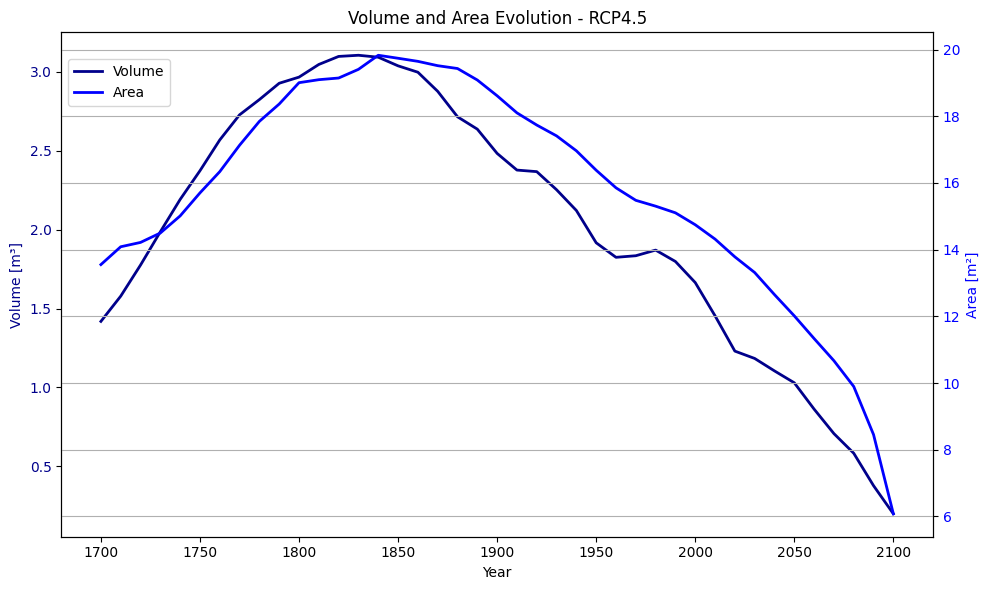

In [95]:
import xarray as xr
import matplotlib.pyplot as plt
import glob
import os

# --- Find the latest time series file ---
ts_files = sorted(glob.glob('outputs/*/*/output_ts.nc'))

if not ts_files:
    raise FileNotFoundError("No output_ts.nc file found. Please run the model first.")

ts_file = os.path.abspath(ts_files[-1])
print(f"Using: {ts_file}")

# --- Load time series ---
ds = xr.open_dataset(ts_file)

# Assume variables are named 'volume' and 'area', adjust if different
time = ds["time"].values  # e.g., float years
volume = ds["vol"].values
area = ds["area"].values

# --- Plot Volume and Area together ---
fig, ax1 = plt.subplots(figsize=(10,6))

color_vol = 'darkblue'
ax1.set_xlabel("Year")
ax1.set_ylabel("Volume [m³]", color=color_vol)
ax1.plot(time, volume, color=color_vol, lw=2, label="Volume")
ax1.tick_params(axis='y', labelcolor=color_vol)

# Create a second y-axis for Area
ax2 = ax1.twinx()
color_area = 'blue'
ax2.set_ylabel("Area [m²]", color=color_area)
ax2.plot(time, area, color=color_area, lw=2, label="Area")
ax2.tick_params(axis='y', labelcolor=color_area)

# Optional: Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines_1 + lines_2,
    labels_1 + labels_2,
    loc='upper left',      # Positionierung relativ zum Anker
    bbox_to_anchor=(0, 0.96)  # x=0 (links), y=0.95 (leicht tiefer)
)


plt.title("Volume and Area Evolution - RCP4.5")
plt.grid(True)
plt.tight_layout()
plt.show()


## Glacier Ice Thickness Evolution

Let's visualize how the ice thickness evolved over time in a 4x4 grid showing 16 time steps.

Found 1 output file(s)



/content/glamod/03_notebook/helper.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.96])


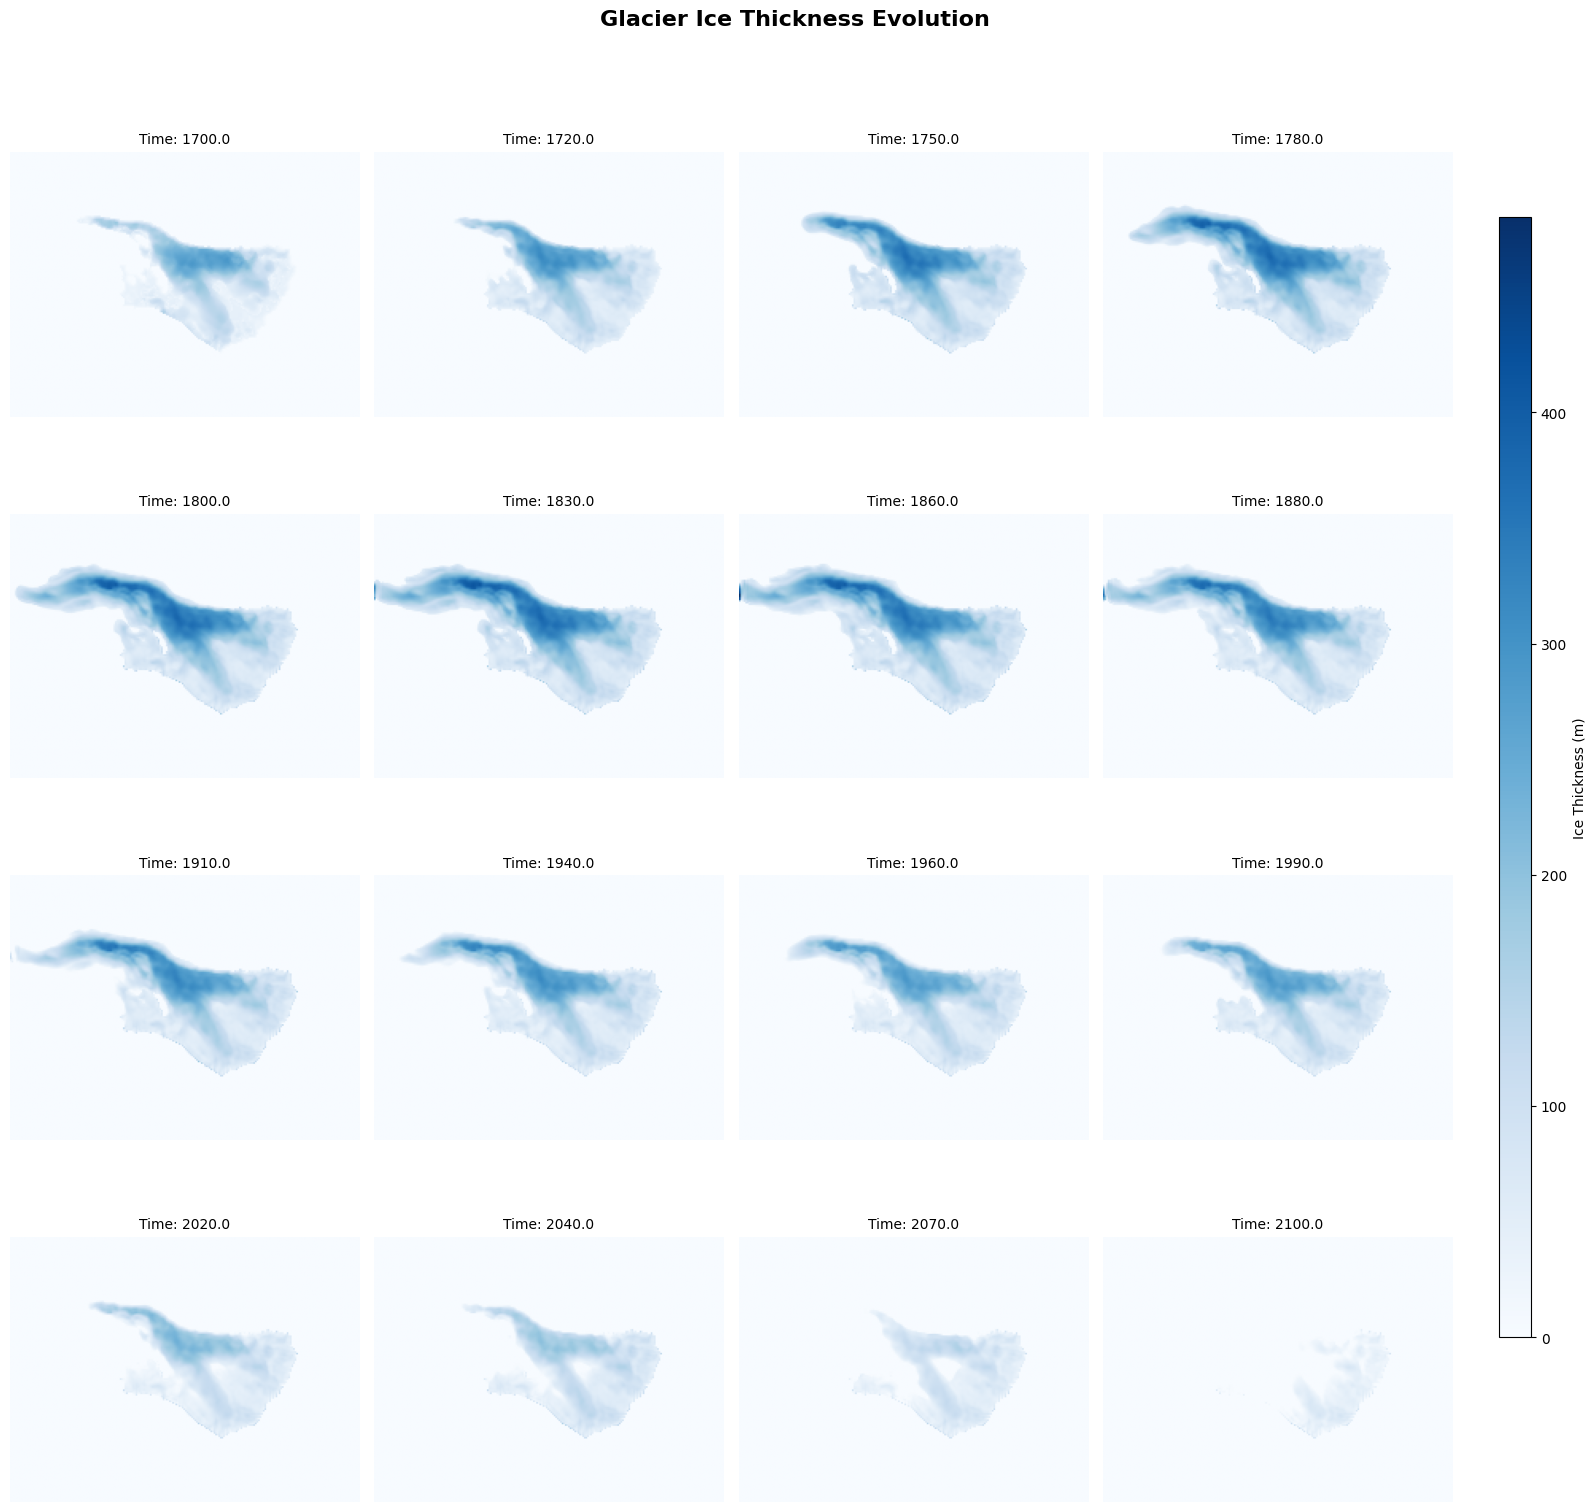

In [14]:
from helper import *
import glob

# Find all output files
A = glob.glob('outputs/*/*/output.nc')

if A:
    print(f"Found {len(A)} output file(s)\n")
    # Animate ice thickness evolution
    animate_glacier_evolution(
        nc_file=A[-1],
        variable='thk',
        log_scale=False
    )
else:
    print("No output.nc files found. Please run the model first.")

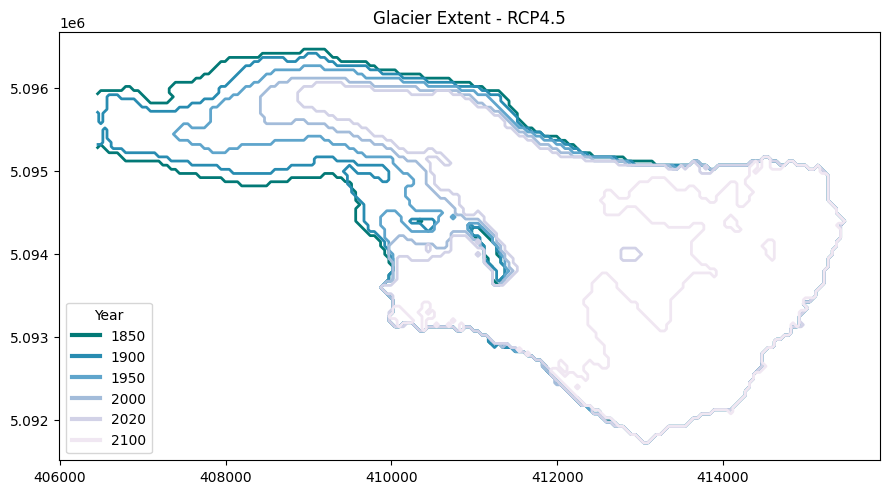

In [92]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob

# Load output.nc
A = glob.glob('outputs/*/*/output.nc')
ds = xr.open_dataset(A[-1])

# Read coordinates
x = ds["x"].values      # length 220
y = ds["y"].values      # length 167

# Meshgrid aligned correctly with thk[y, x]
X, Y = np.meshgrid(x, y, indexing='xy')

# Time is float years
years = ds["time"].values   # e.g., 1850.0

target_years = [1850, 1900, 1950, 2000, 2020, 2100]
THRESH = 1.0

# ---------------------------------------
# Compute combined mask for auto-centering
# ---------------------------------------
combined_mask = np.zeros((len(y), len(x)), dtype=bool)

for yr in target_years:
    idx = np.abs(years - yr).argmin()
    thk = ds["thk"].isel(time=idx).values
    combined_mask |= (thk > THRESH)

ys, xs = np.where(combined_mask)

x_min, x_max = x[xs].min(), x[xs].max()
y_min, y_max = y[ys].min(), y[ys].max()

# Add margins
dx = (x_max - x_min) * 0.05
dy = (y_max - y_min) * 0.05

# ---------------------------------------
cmap = plt.cm.PuBuGn_r
colors = [cmap(v) for v in np.linspace(0.2, 0.9, len(target_years))]

# ---------------------------------------
# Plot
# ---------------------------------------
plt.figure(figsize=(9, 7))

for yr, col in zip(target_years, colors):
    idx = np.abs(years - yr).argmin()
    thk = ds["thk"].isel(time=idx).values

    mask = thk > THRESH

    plt.contour(
        X, Y, mask,
        levels=[0.5],
        colors=[col],
        linewidths=2
    )

plt.xlim(x_min - dx, x_max + dx)
plt.ylim(y_min - dy, y_max + dy)
plt.gca().set_aspect('equal')

#plt.xlabel("X [m]")
#plt.ylabel("Y [m]")
plt.title("Glacier Extent - RCP4.5")

handles = [plt.Line2D([0], [0], color=c, lw=3) for c in colors]
#plt.legend(handles, [str(yr) for yr in target_years], title="Year")
plt.legend(handles, [str(yr) for yr in target_years], title="Year", loc='lower left')

plt.tight_layout()
plt.show()


Using: /content/glamod/03_notebook/outputs/2025-12-05/15-09-48/output_ts.nc


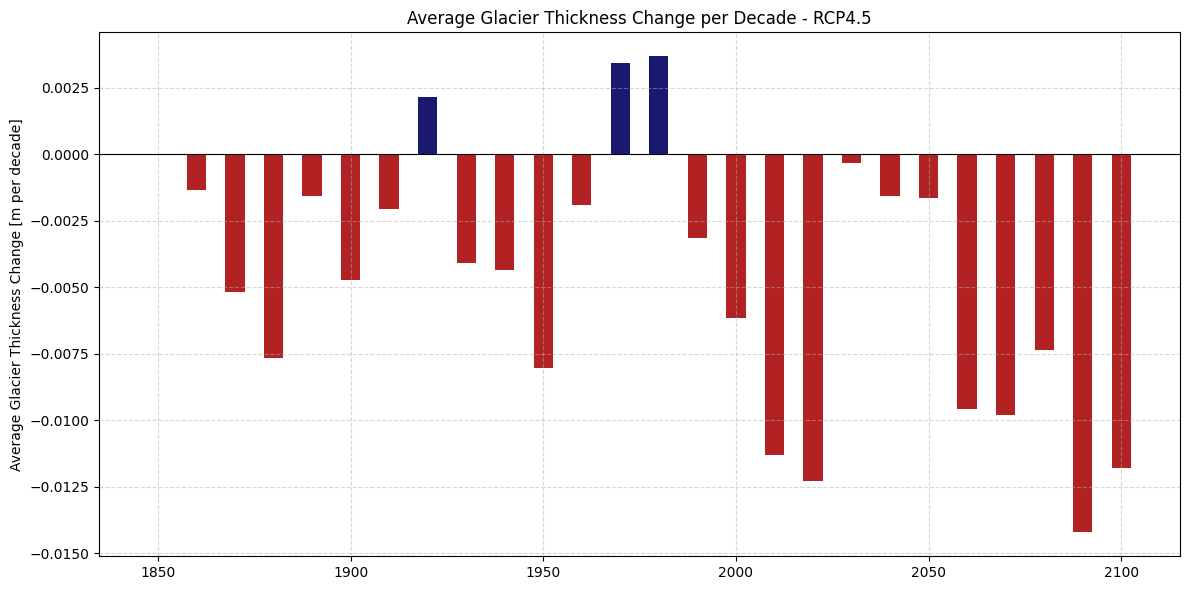

In [96]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

# --- Find the latest time series file ---
ts_files = sorted(glob.glob('outputs/*/*/output_ts.nc'))
if not ts_files:
    raise FileNotFoundError("No output_ts.nc file found.")
ts_file = os.path.abspath(ts_files[-1])
print(f"Using: {ts_file}")

ds = xr.open_dataset(ts_file)

# --- Extract variables ---
time = ds["time"].values        # years
vol = ds["vol"].values          # volume [m³]
area = ds["area"].values        # area [m²]

# --- Compute average thickness per year ---
avg_thk = vol / area  # in meters

# --- Filter for years >= 1850 ---
mask = time >= 1850
time = time[mask]
avg_thk = avg_thk[mask]

# --- Compute decadal change ---
decades = (np.floor(time / 10) * 10).astype(int)
unique_decades = np.unique(decades)

# Average thickness per decade
avg_thk_decade = np.array([avg_thk[decades == d].mean() for d in unique_decades])

# Compute change relative to previous decade
thk_change_decade = np.diff(avg_thk_decade, prepend=avg_thk_decade[0])

# --- Plot centered bar chart ---
fig, ax = plt.subplots(figsize=(12,6))
colors = ['midnightblue' if v >= 0 else 'firebrick' for v in thk_change_decade]
ax.bar(unique_decades, thk_change_decade, width=5, color=colors, align='center')
ax.axhline(0, color='black', linewidth=0.8)
#ax.set_xlabel("Year")
ax.set_ylabel("Average Glacier Thickness Change [m per decade]")
ax.set_title("Average Glacier Thickness Change per Decade - RCP4.5")
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Glacier Velocity Evolution

Now let's visualize the ice velocity magnitude evolution in log scale. This shows the flow dynamics and where the glacier is moving fastest.

Found 1 output file(s)



/content/glamod/03_notebook/helper.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.96])


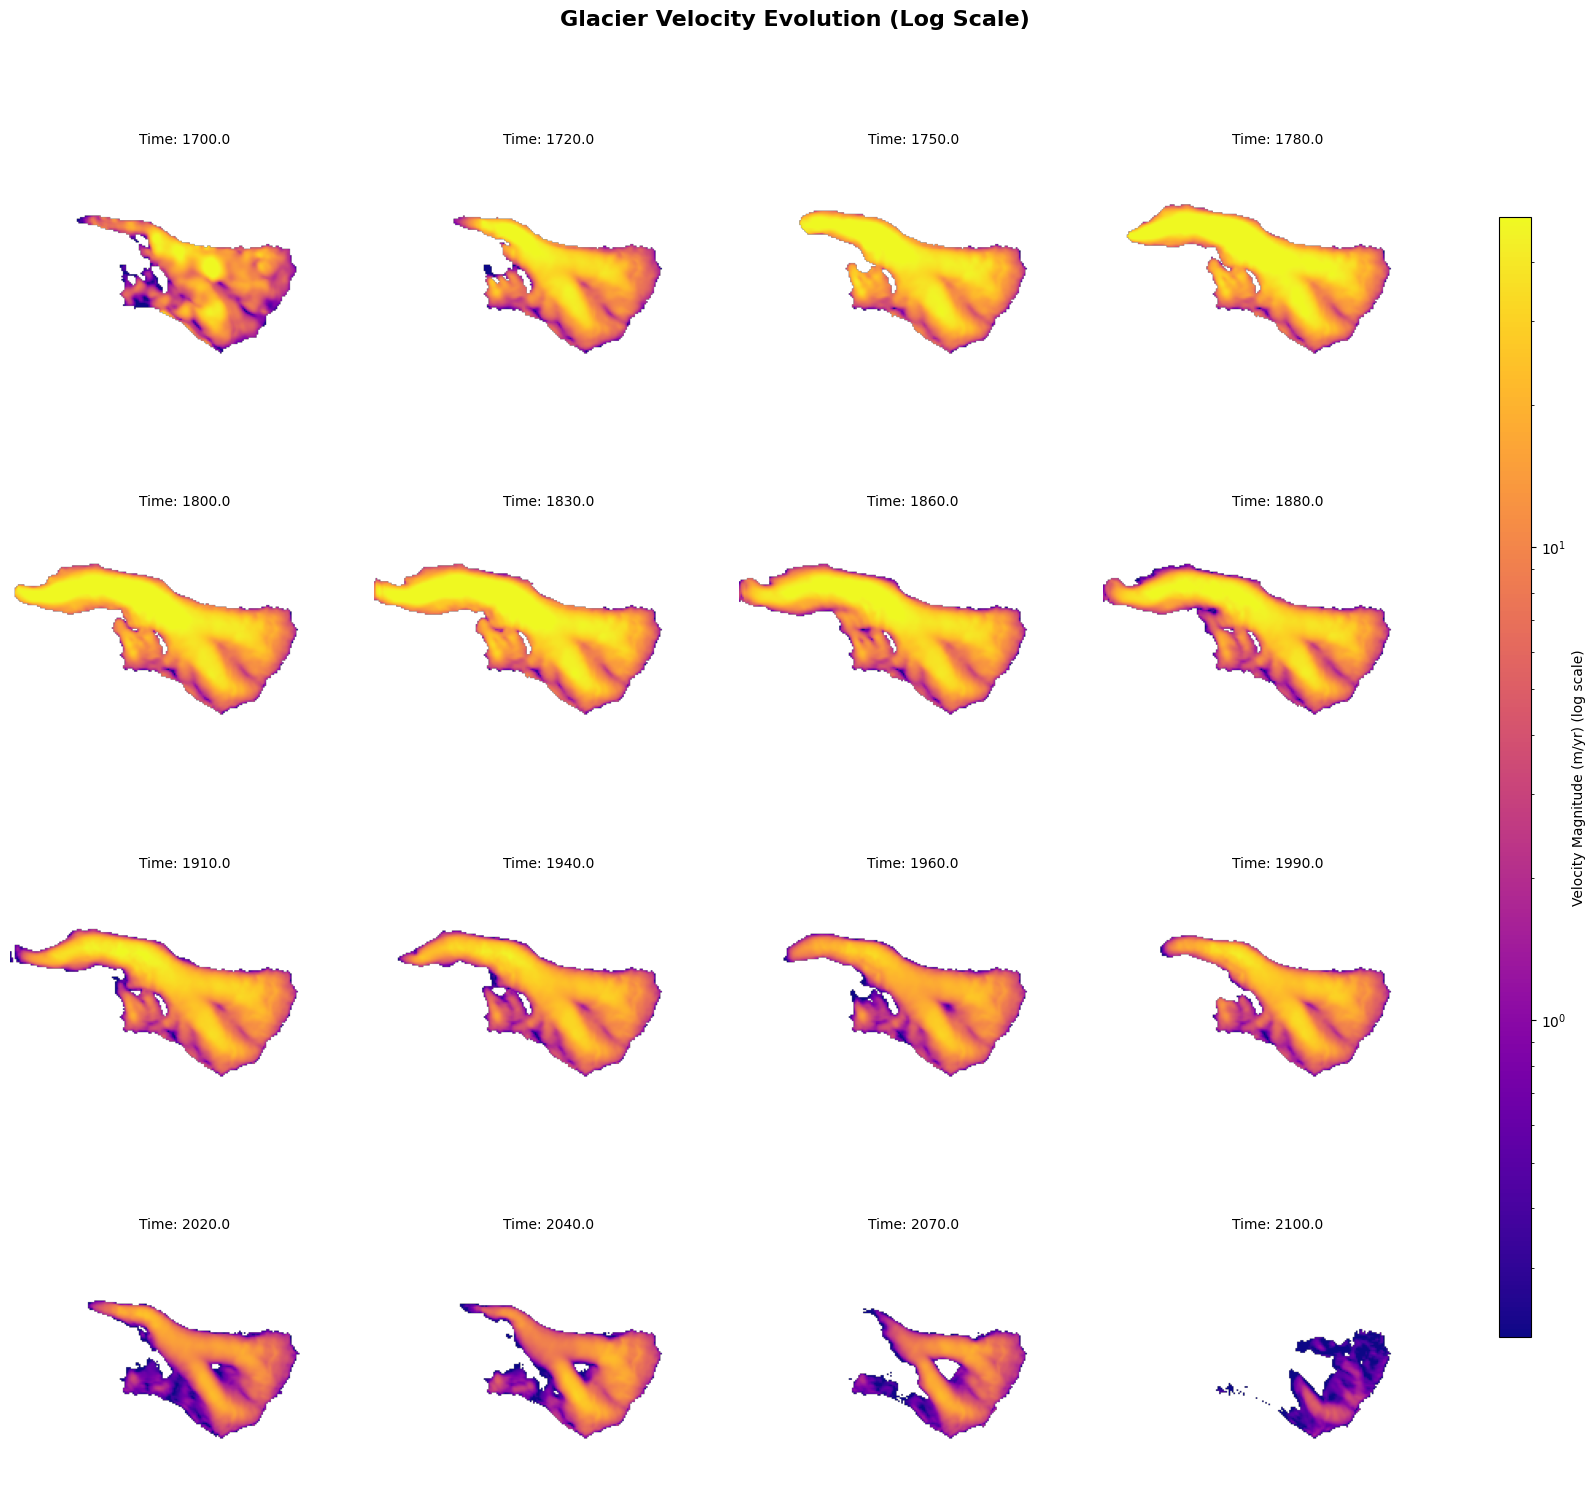

In [15]:
import importlib
import helper
importlib.reload(helper)
from helper import *
import glob

# Find all output files
A = glob.glob('outputs/*/*/output.nc')

if A:
    print(f"Found {len(A)} output file(s)\n")
    # Plot velocity evolution (log scale)
    animate_glacier_evolution(
        nc_file=A[-1],
        variable='velbar_mag',
        log_scale=True
    )
else:
    print("No output.nc files found. Please run the model first.")

Using: /content/glamod/03_notebook/outputs/2025-12-05/15-09-48/output.nc


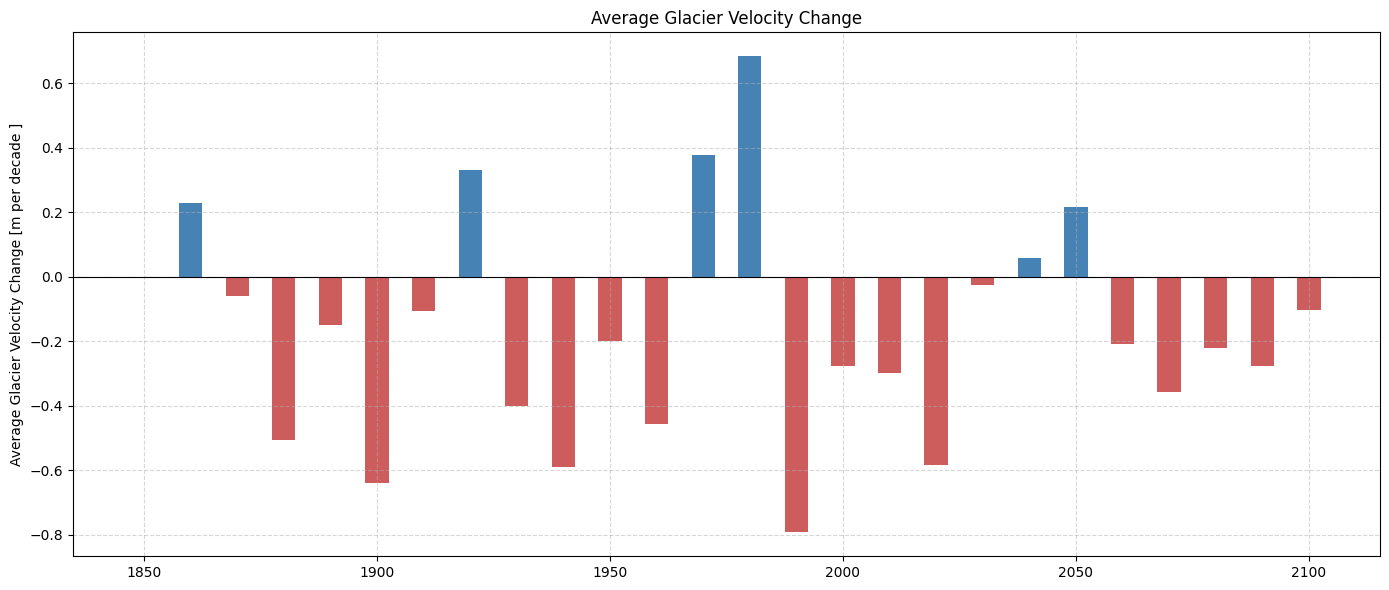

In [94]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

# --- Find the latest output.nc file ---
nc_files = sorted(glob.glob('outputs/*/*/output.nc'))
if not nc_files:
    raise FileNotFoundError("No output.nc file found.")
nc_file = os.path.abspath(nc_files[-1])
print(f"Using: {nc_file}")

# --- Load dataset ---
ds = xr.open_dataset(nc_file)

# --- Extract time and velocity ---
time = ds["time"].values            # years
vel = ds["velbar_mag"].values       # shape: (time, x, y)

# --- Filter years >= 1850 ---
mask = time >= 1850
time = time[mask]
vel = vel[mask, :, :]

# --- Compute average velocity per year ---
avg_vel_yearly = vel.mean(axis=(1,2))  # mean over spatial dimensions

# --- Compute yearly change (difference to previous year) ---
vel_change_yearly = np.diff(avg_vel_yearly, prepend=avg_vel_yearly[0])

# --- Plot centered bar chart ---
fig, ax = plt.subplots(figsize=(14,6))
colors = ['steelblue' if v >= 0 else 'indianred' for v in vel_change_yearly]
ax.bar(time, vel_change_yearly, width=5.0, color=colors, align='center')
ax.axhline(0, color='black', linewidth=0.8)
#ax.set_xlabel("Year")
ax.set_ylabel("Average Glacier Velocity Change [m per decade ]")
ax.set_title("Average Glacier Velocity Change - RCP4.5")
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [63]:
print(ds)


<xarray.Dataset> Size: 48MB
Dimensions:      (time: 41, y: 167, x: 220, z: 10)
Coordinates:
  * time         (time) float32 164B 1.7e+03 1.71e+03 ... 2.09e+03 2.1e+03
  * y            (y) float32 668B 5.09e+06 5.09e+06 ... 5.098e+06 5.098e+06
  * x            (x) float32 880B 4.064e+05 4.065e+05 ... 4.173e+05 4.174e+05
  * z            (z) int64 80B 0 1 2 3 4 5 6 7 8 9
Data variables:
    topg         (time, y, x) float32 6MB ...
    usurf        (time, y, x) float32 6MB ...
    thk          (time, y, x) float32 6MB ...
    smb          (time, y, x) float32 6MB ...
    velbar_mag   (time, y, x) float32 6MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    velsurf_mag  (time, y, x) float32 6MB ...
    uvelsurf     (time, y, x) float32 6MB ...
    vvelsurf     (time, y, x) float32 6MB ...
Attributes:
    pyproj_srs:  


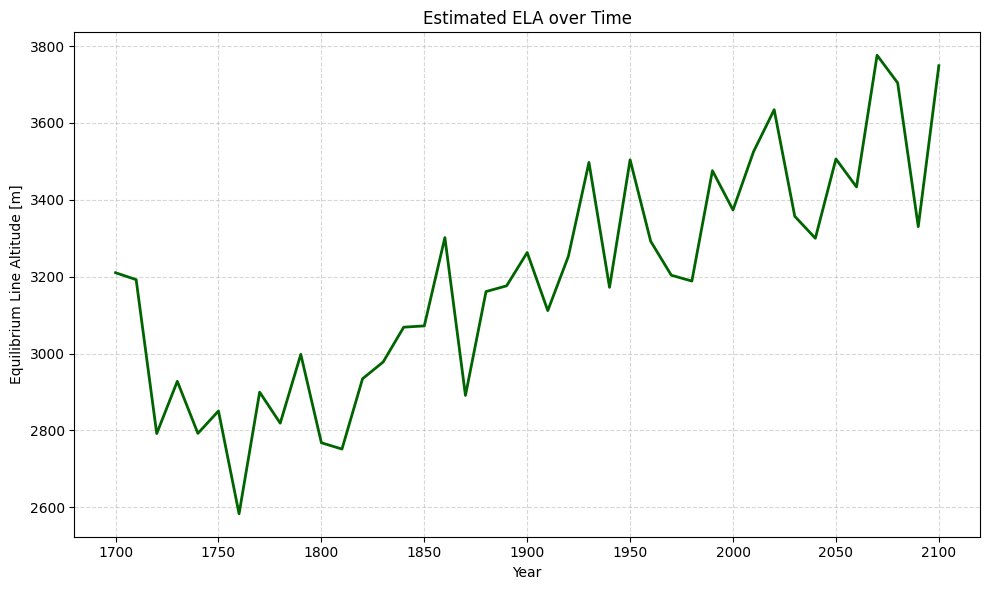

In [64]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

# --- Load latest output.nc ---
nc_files = sorted(glob.glob('outputs/*/*/output.nc'))
nc_file = os.path.abspath(nc_files[-1])
ds = xr.open_dataset(nc_file)

# --- Extract variables ---
time = ds["time"].values
topg = ds["topg"].values        # bed elevation
thk = ds["thk"].values          # ice thickness
smb = ds["smb"].values          # surface mass balance

# --- Surface elevation ---
usurf = ds["usurf"].values      # surface elevation (topg + thk)

ela_yearly = []
for t in range(len(time)):
    smb_t = smb[t,:,:]
    usurf_t = usurf[t,:,:]

    # Flatten arrays to 1D
    smb_flat = smb_t.flatten()
    usurf_flat = usurf_t.flatten()

    # ELA: mean elevation where smb ~ 0
    mask = np.isclose(smb_flat, 0, atol=1e-3)  # Toleranz anpassen
    if mask.any():
        ela = usurf_flat[mask].mean()
    else:
        # falls kein smb=0, lineare Interpolation
        sorted_idx = np.argsort(smb_flat)
        smb_sorted = smb_flat[sorted_idx]
        usurf_sorted = usurf_flat[sorted_idx]
        idx = np.searchsorted(smb_sorted, 0)
        if idx == 0:
            ela = usurf_sorted[0]
        elif idx >= len(smb_sorted):
            ela = usurf_sorted[-1]
        else:
            # linear interpolation
            x0, x1 = smb_sorted[idx-1], smb_sorted[idx]
            y0, y1 = usurf_sorted[idx-1], usurf_sorted[idx]
            ela = y0 + (0 - x0) * (y1 - y0) / (x1 - x0)
    ela_yearly.append(ela)

# --- Plot ---
plt.figure(figsize=(10,6))
plt.plot(time, ela_yearly, color='darkgreen', lw=2)
plt.xlabel("Year")
plt.ylabel("Equilibrium Line Altitude [m]")
plt.title("Estimated ELA over Time")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Glacier Cross-Section Along Flowline

Now let's visualize how the glacier thickness evolved along the flowline over time. This will show the bedrock elevation, ice thickness, and surface elevation at 16 different time steps in a 4x4 grid.

Each subplot includes:
- **Left y-axis (blue)**: Elevation in meters - showing bedrock (black line), ice (blue fill), and surface (blue line)
- **Right y-axis (red)**: Ice velocity magnitude in m/yr (red line)

**Note:** The flowline automatically extends upward from the OGGM downstream line to capture the upper part of the glacier where ice is present.

Found 1 output file(s)

Reading glacier evolution data from: outputs/2025-12-05/15-09-48/output.nc
Reading flowline data from: data/RGI2000-v7.0-G-11-01189/downstream_line.pkl

OGGM grid: origin=(406444.97, 5098045.05), resolution=(50.0, -50.0)
Flowline loaded: 22 points

Extending flowline to capture upper glacier...
  Extended flowline by 5 points (0.50 km)
  Total flowline points: 27



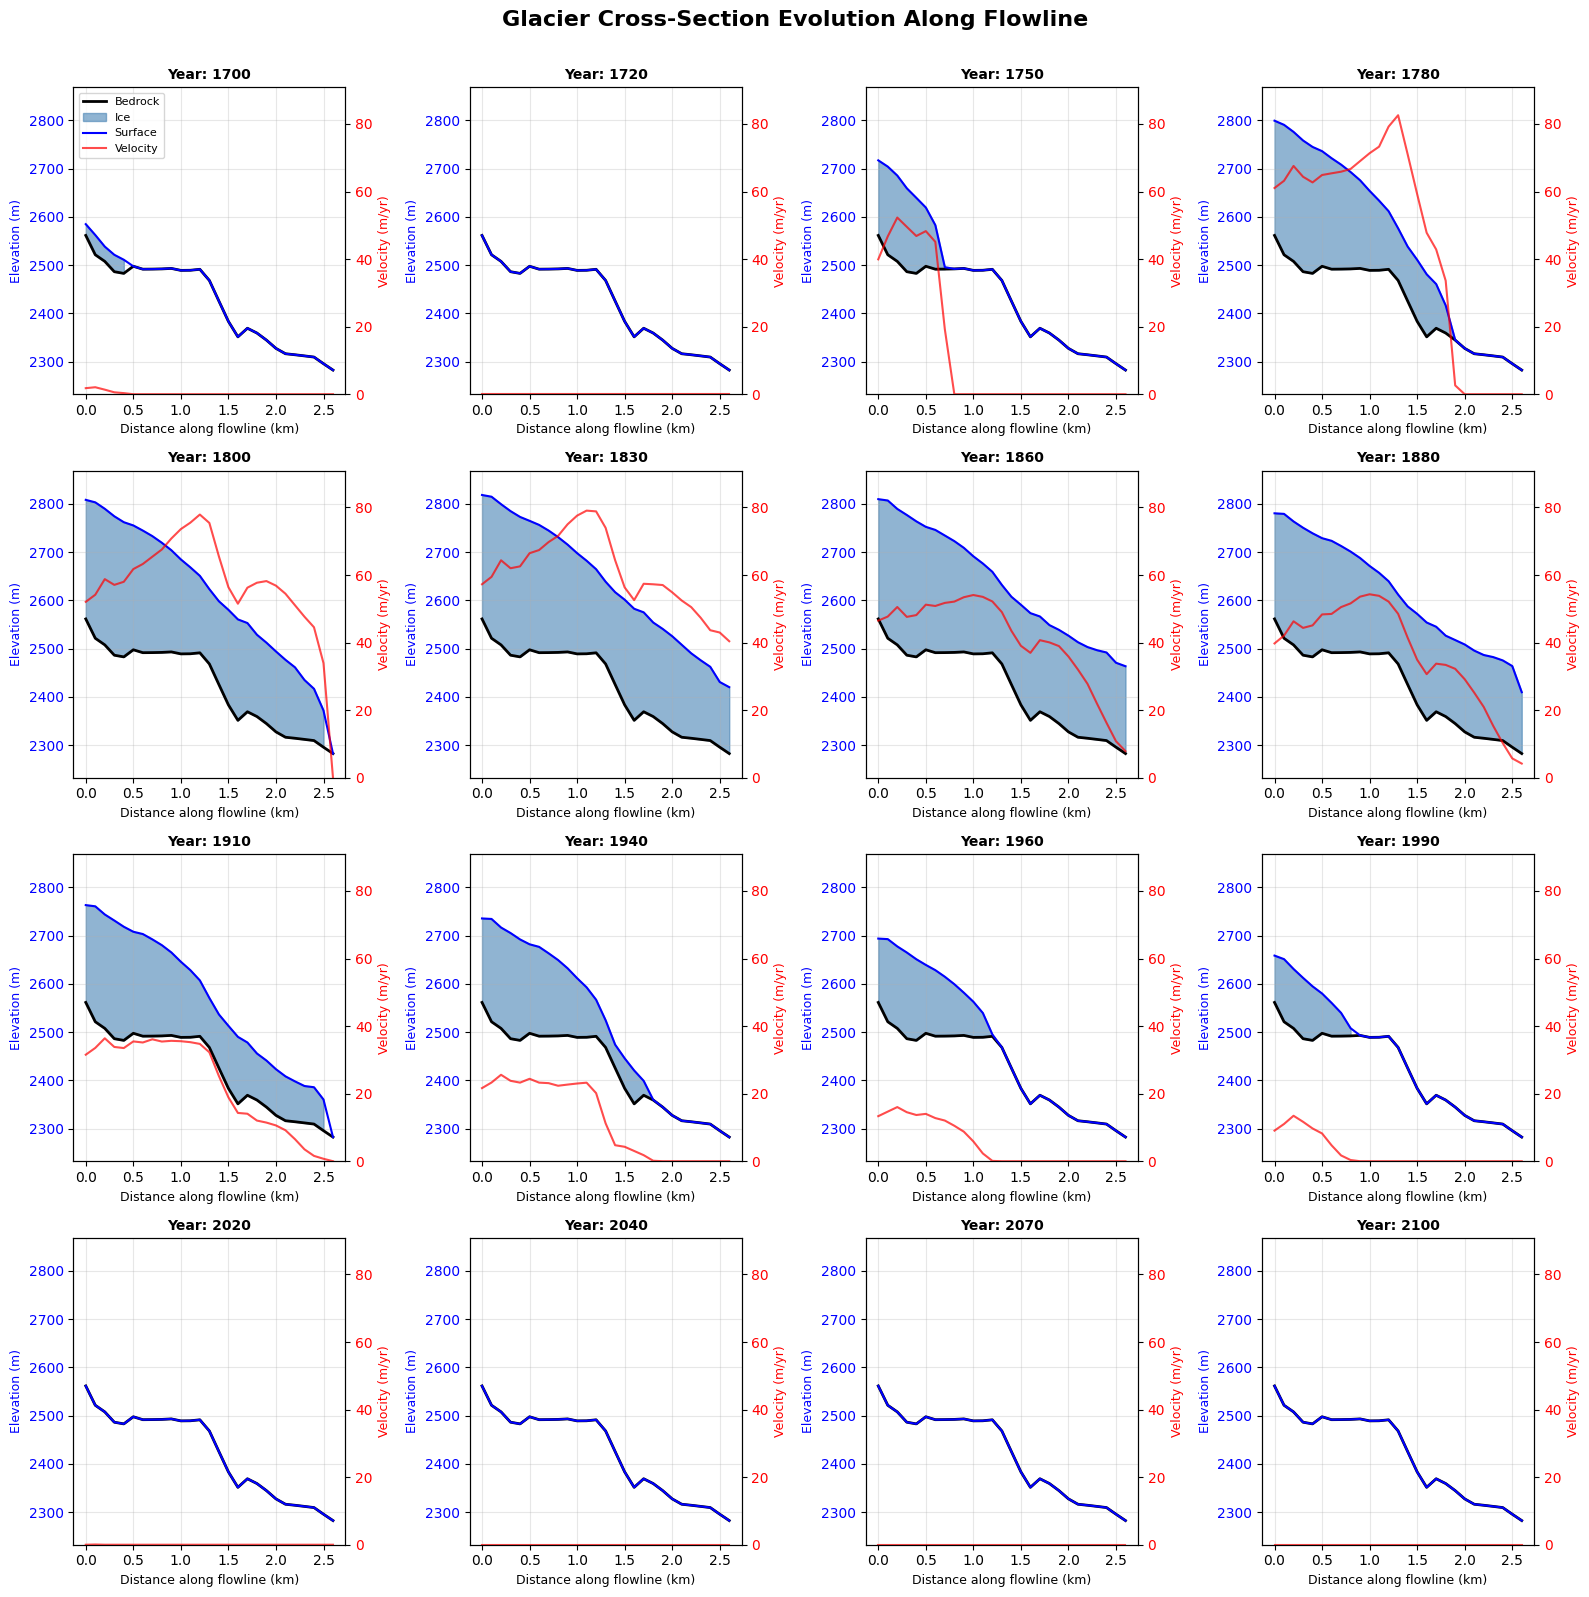


Flowline length: 2.60 km
Time period: 1700 - 2100


In [19]:
import importlib
import helper
importlib.reload(helper)
from helper import *
import glob

# Find all output files
A = glob.glob('outputs/*/*/output.nc')

if A:
    print(f"Found {len(A)} output file(s)\n")
    # Plot flowline evolution for the last run
    plot_flowline_evolution(
        nc_file=A[-1],
        flowline_file='data/RGI2000-v7.0-G-11-01189/downstream_line.pkl',
        glacier_grid_file='data/RGI2000-v7.0-G-11-01189/glacier_grid.json'
    )
else:
    print("No output.nc files found. Please run the model first.")

## Compare Modeled vs Observed Velocity

Compare the modeled surface velocity with observations from the input data.

Found 1 output file(s). Using: outputs/2025-12-05/15-09-48/output.nc

Comparing modeled (year 2020) vs observed velocity

Using modeled data from year: 2020.0


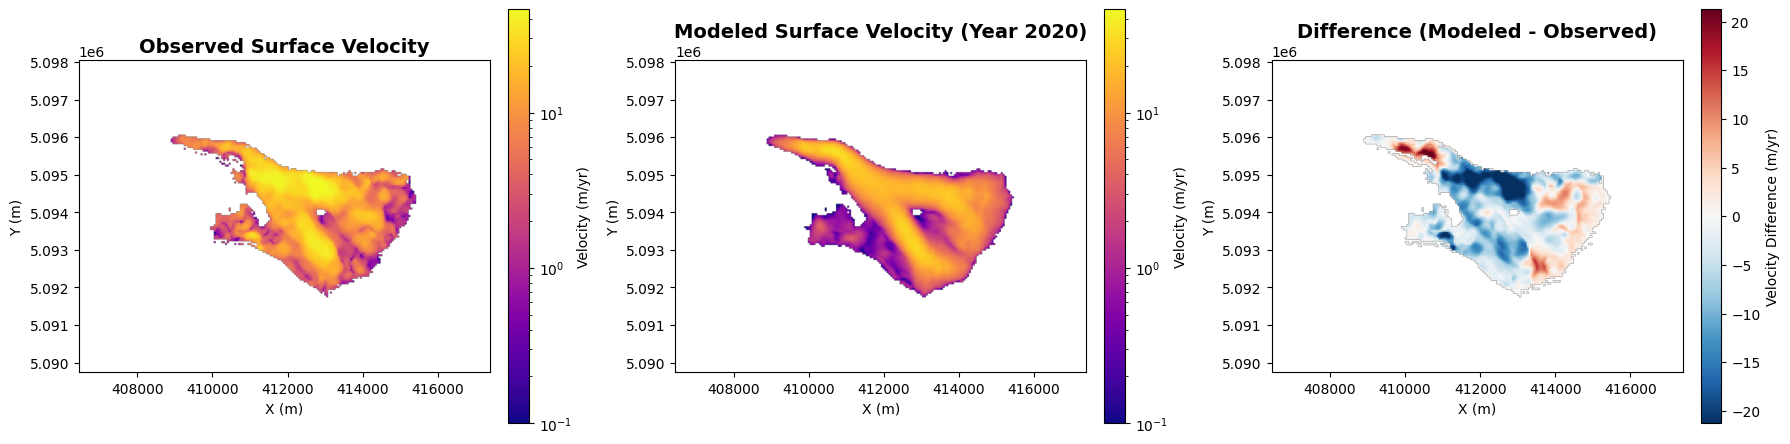


VELOCITY COMPARISON STATISTICS
Correlation coefficient (R): 0.673
RMSE: 9.66 m/yr
Bias (modeled - observed): -4.33 m/yr
Number of points: 5269

Observed velocity range: 0.00 - 54.60 m/yr
Modeled velocity range: 0.02 - 32.04 m/yr


In [17]:
import importlib
import helper
importlib.reload(helper)
from helper import compare_modeled_observed_velocity
import glob

# Find all output files and use the latest one
output_files = sorted(glob.glob('outputs/*/*/output.nc'))

if output_files:
    print(f"Found {len(output_files)} output file(s). Using: {output_files[-1]}\n")
    # Compare modeled velocity (year 2020) with observed velocity
    compare_modeled_observed_velocity(
        input_file='data/input.nc',
        output_file=output_files[-1],
        year=2020
    )
else:
    print("No output.nc files found. Please run the model first.")